In [4]:
# Import using scikit-video
import skvideo.io
import skvideo.datasets
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def video_to_ndarray(path):
    """
    Parse a video file to an ndarray. Only works for complete formats, which include video metadata.
    """
    videodata = skvideo.io.vread(path)
    print("Shape: ", videodata.shape)
    return videodata

stack = video_to_ndarray("V:\\Downloads\\SwimmingAlgaeVideos\\CanSeeTwoOrThreePart.h264")

Shape:  (292, 1080, 1920, 3)


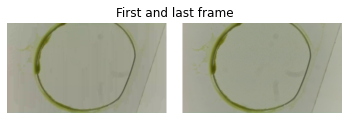

In [5]:
%matplotlib inline
def preview(stack):
    """
    Shows the first and last frame of the image stack.
    """
    hstack = np.hstack([stack[0], np.full((stack[0].shape[0], \
                        round(stack[0].shape[1]*0.1), stack[0].shape[2]), 255, dtype=stack[0].dtype),
                        stack[-1]])
    plt.title("First and last frame")
    plt.axis('off')
    plt.imshow(hstack)
preview(stack)

In [110]:
def crop_stack(stack):
    """
    Crops the entire stack to a circular field of view by object etection. #TODO 
    Assumes that the first dimension is the number of frames.
    """
    # Crop image
    pass
    import numpy as np
    videodata_ = np.ndarray([videodata.shape[0], 1500-250, videodata.shape[2], videodata.shape[3]])
    videodata_.shape

In [9]:
def get_color_ch(stack, ch_id):
    """
    Returns a particlar color channel.
    """
    
    if isinstance(ch_id, str):
        map_ = {'r': 0, 'g': 1, 'b': 2}
        ch_id = map_[ch_id]
    channel = stack[:, :, :, ch_id]
    return channel

def grayscale_float(stack, cast=np.uint8):
    """
    Returns a float64 image, which is not very useful.
    """
    from skimage.color import rgb2gray
    return np.astype(np.round(rgb2gray(stack)))


#gray = grayscale(stack)


(292, 1080, 1920)
uint8


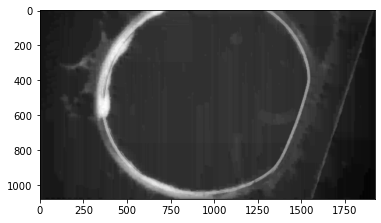

In [10]:
blue = get_color_ch(stack, 'b')
print(blue.shape)
print(blue[0].dtype)
plt.imshow(blue[0],cmap='gray')
plt.imshow(np.invert(blue[0]),cmap='gray')


In [ ]:
from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte

def auto_crop_circle(image_, invert=False):
    
    if invert:
        image = np.invert(image_)
    else:
        image = np.copy(image_)
    
    # Load picture and detect edges
    #image = img_as_ubyte(data.coins()[160:230, 70:270])
    edges = canny(image, sigma=2.5, low_threshold=10, high_threshold=50)
    edges = np.invert(edges)
    #plt.imshow(edges, cmap='gray')

    # Detect two radii
    hough_radii = np.arange(*[int(round(x*0.8)) for x in list(image.shape)])    
    hough_res = hough_circle(edges, hough_radii)
    
    # Select the most prominent 3 circles
    accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                               total_num_peaks=3)

    # Draw them
    plt.imshow(image)
    circles = []
    for center_y, center_x, radius in zip(cy, cx, radii):
        circles.append(circle_perimeter(center_y, center_x, radius,
                                        shape=image.shape))
    print(len(circles))
    plt.plot(circles[0])

print(blue[0].shape)
auto_crop_circle(blue[0], invert=False)

(1080, 1920)


13


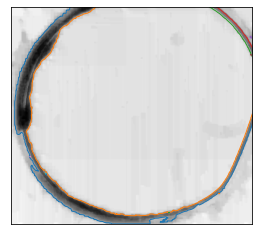

(2880, 2)


In [135]:

def counters(image):
    from skimage import measure

    # Find contours at a constant value of 0.8
    contours = measure.find_contours(image, 100, fully_connected='high')

    # Display the image and plot all contours found
    fig, ax = plt.subplots()
    ax.imshow(image, cmap=plt.cm.gray)

    print(len(contours))
    for contour in contours:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=1)

    ax.axis('image')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()
    print(contours[1].shape)
counters(blue[0])

In [ ]:
# Recommended ways of Trackpy
import pims
import trackpy as tp

(1080, 1200)


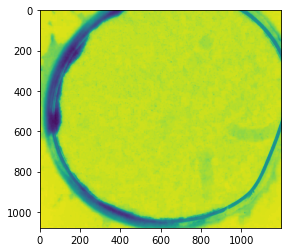

In [6]:
blue_channel = videodata_[:, :, :, 2]
print(blue_channel[100].shape)
plt.imshow(blue_channel[100])

(1080, 1200)


<IPython.core.display.Javascript object>


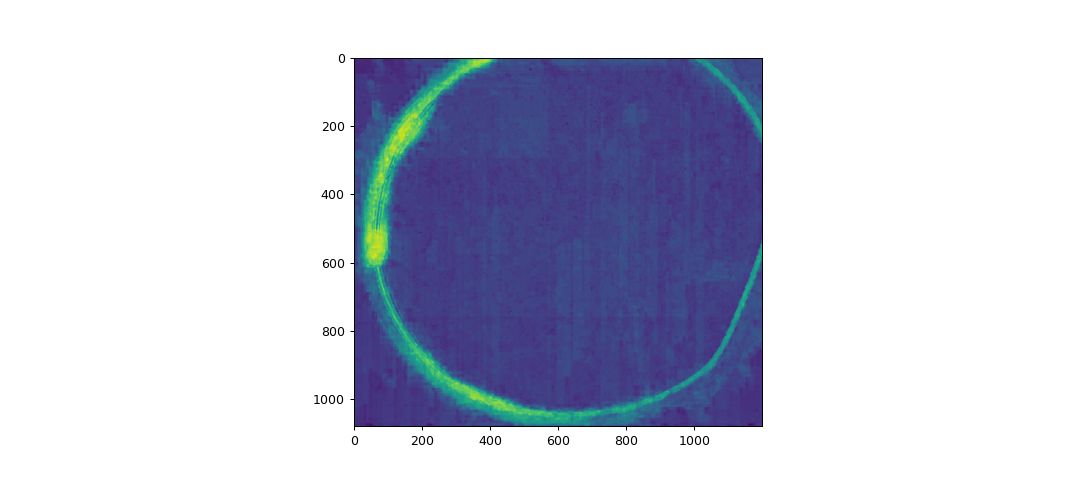

In [19]:
#Noise reduction
def denoise_simple(stack, normalize=False, ref_image=None, preview=False):
    
    if ref_image == None:
            ref_image = (stack[0] + stack[-1] / 2)
    
    # Remove background
    new_stack = stack - ref_image
    
    a
    
    if preview: # Something from the middle
        plt.imshow(new_stack[int(new_stack.shape/2)])

359


[Text(0.5, 0, 'mass'), Text(0, 0.5, 'count')]

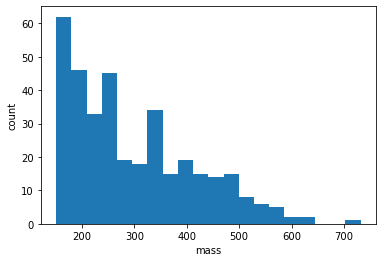

In [8]:
f = tp.locate(blue[0], 11, invert=True,  minmass=150)
print(len(f))
f.head()

fig, ax = plt.subplots()
ax.hist(f['mass'], bins=20)

# Optionally, label the axes.
ax.set(xlabel='mass', ylabel='count')

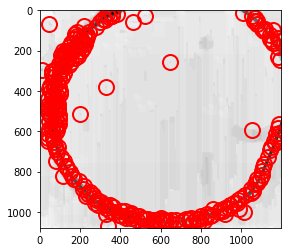

In [52]:
tp.annotate(f, green_channel[0]);

In [9]:
f_ = tp.batch(blue_channel[:], 11, minmass=150, invert=True);


Frame 291: 434 features


In [12]:
# Smaller average speed parameter used.
t = tp.link(f_, 13, memory=50) #Create trajectories
t1 = tp.filter_stubs(t, 25)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())


Frame 291: 434 trajectories present.
Before: 2451
After: 891


<IPython.core.display.Javascript object>


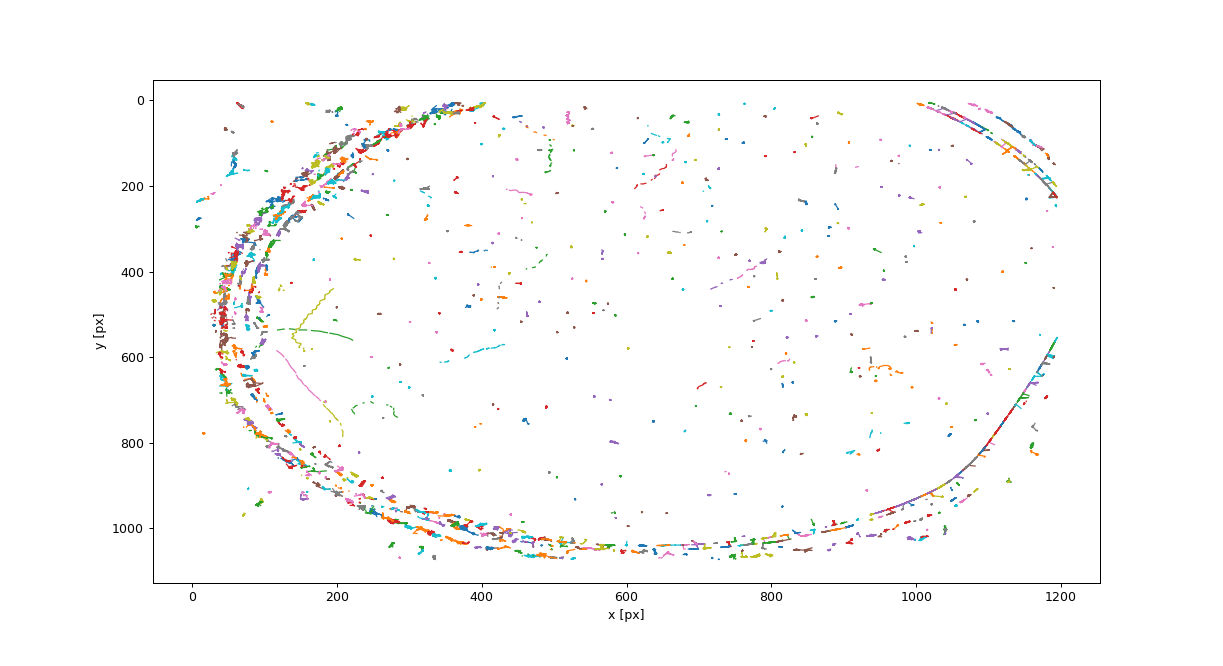

<AxesSubplot:xlabel='x [px]', ylabel='y [px]'>

In [13]:
%matplotlib notebook
plt.figure()
tp.plot_traj(t1)

183420


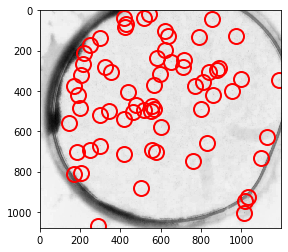

<AxesSubplot:>

In [15]:
%matplotlib inline
# Additional filtering
t2 = t1[((t1['mass'] > 50) & (t1['size'] < 2.6) &
         (t1['ecc'] < 0.3))]
print(t2.size)
plt.figure()
tp.annotate(t2[t2['frame'] == 100], blue_channel[100])

<IPython.core.display.Javascript object>


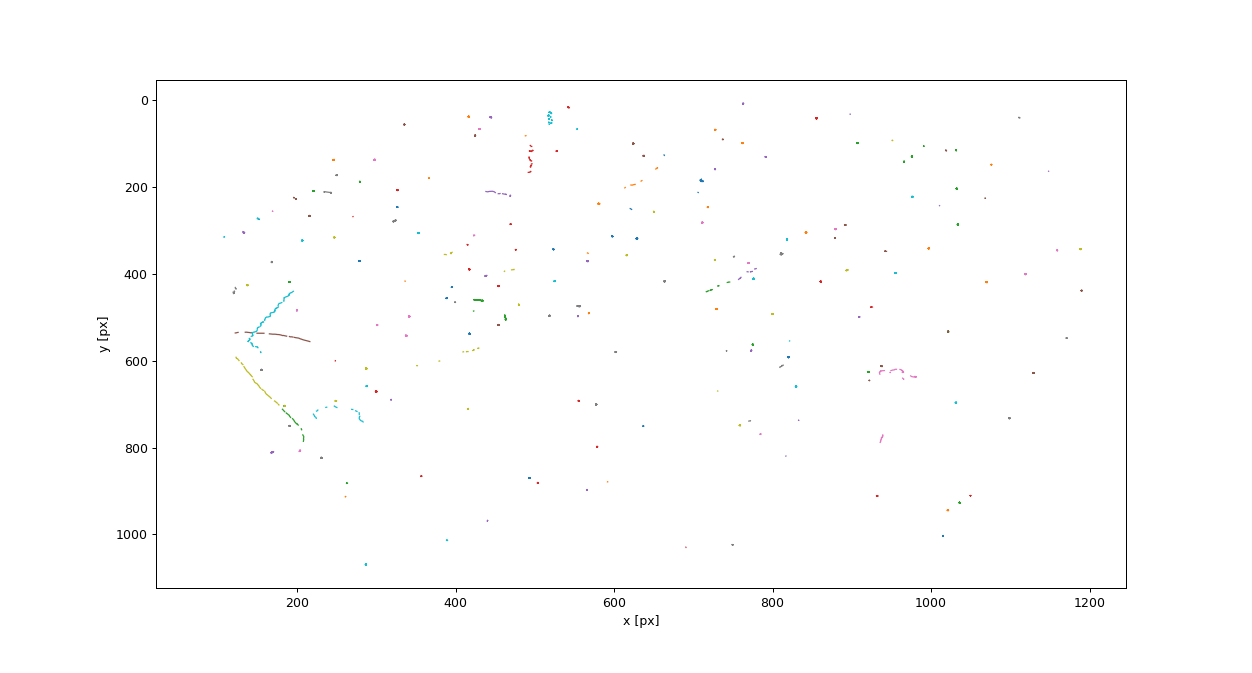

<AxesSubplot:xlabel='x [px]', ylabel='y [px]'>

In [17]:
%matplotlib notebook
plt.figure()
tp.plot_traj(t2)